In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import matplotlib
import csv
import ast
from torch.autograd import Variable
import torchvision.transforms as transforms

# 1. Data Loading

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
dataset_root_dir = '/datasets/COCO-2015/'

In [4]:
'''Create file list in COCO dataset directory'''
def create_filelist(dataset_root_dir, mode="train2014/"):
    path=os.path.join(dataset_root_dir, mode)
    file_list=[]
    for file in os.listdir(path):
        file_list.append(file)
    return file_list

train_list=create_filelist(dataset_root_dir, mode="train2014/")
test_list=create_filelist(dataset_root_dir, mode="test2015/")

In [5]:
'''COCO Dataset class that loads images from COCO dataset'''
class COCODataset(td.Dataset):
    def __init__(self, root_dir, data_list, mode="train2014/", image_size=(256,256)):
        super(COCODataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.data = data_list
        self.images_dir = os.path.join(root_dir, mode)

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        return "COCODataset(mode={}, image_size={})". \
               format(self.mode, self.image_size)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, \
                                self.data[idx])
        img = Image.open(img_path).convert('RGB')
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
            ])
        x = transform(img)
        return x

    def number_of_classes(self):
        return self.data['class'].max() + 1

In [6]:
'''Loda training set and testing set'''
train_set = COCODataset(dataset_root_dir,train_list)
test_set = COCODataset(dataset_root_dir,test_list,mode="test2015/")

In [7]:
'''Image display function'''
def imshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

# 2. Model <br />
## 2.1 Transformation Network

In [8]:
from trans_net import TransNet

## 2.2 Loss Network

In [9]:
'''Loss network --
       VGG16 (frozen). The output is the feature maps of 3, 8, 15, 22 layers.
       No forward output from the last layer
'''
class LossNet(nn.Module):
    def __init__(self):
        super(LossNet, self).__init__()
        self.vgg = tv.models.vgg16(pretrained=True).features
        self.layers = [3, 8, 15, 22]
        for param in self.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        feature_list = []
        h = x
        for nLayer in range(max(self.layers)+1):
            h = self.vgg[nLayer](h)
            if nLayer in self.layers:
                feature_list.append(h)
            
        return feature_list

# 3. Loss function

In [10]:
'''Gram matrix calculation function'''
def gram_matrix(input):
    a, b, c, d = input.size()  
    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    G = torch.mm(features, features.t())  # compute the gram product
    gramMatrix = G.div(a * b * c * d)
    return gramMatrix

def StyleGram(style):
    style_gram = []
    for layer in range(len(style)):
        style_gram.append(gram_matrix(style[layer]))
    return style_gram

'''Style loss function'''
def loss_style(y_feature_list, style_feature_list):
    styleLoss_sum = 0
    Style_Gram = StyleGram(style_feature_list)
    feature_pred = y_feature_list
    for i in range(len(y_feature_list)):
        gram_s = Style_Gram[i]    
        for j in range(len(y_feature_list[0])):
            gram_y = gram_matrix(y_feature_list[i][j].view(1,y_feature_list[i][j].size()[0], \
                                                           y_feature_list[i][j].size()[1], \
                                                           y_feature_list[i][j].size()[2]))
            styleLoss_sum += torch.sum((gram_y - gram_s)**2)
    styleLoss = styleLoss_sum/len(y_feature_list[0])
    return styleLoss

'''Feature loss function'''
def loss_feat(phi, phi_content):
    return torch.dist(phi, phi_content, 2) / phi.numel()

'''Total variation loss function'''
def loss_tv(outputs):
    t1 = outputs - torch.cat((outputs[:, :, 1:, :], outputs[:, :, -1:, :]), 2)
    t2 = outputs - torch.cat((outputs[:, :, :, 1:], outputs[:, :, :, -1:]), 3)
    tvLoss =  torch.abs(torch.sum(t1+t2) / t1.size()[0])
    return tvLoss

'''Total loss function --
       Calculate the weighted sum of all three above losses. Output the weighted sum and individual loss.
'''
def loss_total(outputs, y_feature_list, style_feature_list, content_feature_list, j_content, J_style):
    feat_loss = loss_feat(y_feature_list[j_content], content_feature_list[j_content])
    style_loss = loss_style(y_feature_list[0:J_style], style_feature_list[0:J_style])
    tv_loss = loss_tv(outputs)
    loss = 3e3*feat_loss + 1*style_loss +1e-5*tv_loss
    loss_list = {'feat_loss':feat_loss, 'style_loss':style_loss, 'tv_loss': tv_loss}
    
    return loss, loss_list

# 4. Run

In [11]:
'''Individual image loader function --
       Used for style image loading
'''
def image_loader(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = tv.transforms.Compose([
        tv.transforms.Resize([256, 256]),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
        ])
    x = transform(img).view([1, 3, 256, 256])
    return x

In [12]:
# Setting parameters
lr = 1e-3  # Learning rate
epoch = 60 # Define how many epoch to train
N = 4000   # Size of training set
B = 10     # Minibatch size
NB = int((N+B-1)/B)

# Checkpoint parameters
style_image_dir = os.getcwd() + '/images/style_image/'
model_dir = os.getcwd() + '/Models/'
style_file_name ='starry_night'
loss_log_file_dir = model_dir + style_file_name + '.txt'
checkpoints_file_dir = model_dir + style_file_name +'.pth.tar'
style_img = image_loader(style_image_dir+style_file_name+'.jpg').to(device)

transnet = TransNet().to(device)
exists = os.path.isfile(checkpoints_file_dir)

# Check if there is checkpoint with same configurations.
# If there is, load the checkpoint.
if exists:
    checkpoint = torch.load(checkpoints_file_dir)
    transnet.load_state_dict(checkpoint)
    del checkpoint
    with open(loss_log_file_dir, 'r') as file:
        data = file.read()
    loss_list = ast.literal_eval(data) 
    epoch_begin = len(loss_list) + 1    
    print('Using check point from epoch ', epoch_begin)

# Store configuration file values
else:
    print('Creating new net')
    loss_list = []
    epoch_begin = 0
    
if epoch_begin >= epoch:
    print('Reach the end of the defined epoch')
else:
    adam = torch.optim.Adam(transnet.parameters(), lr=lr)
    lossnet = LossNet().to(device)
    style_feature_list = lossnet(style_img)
    content_img_set = train_set
    content_img_list = []
    for ii in range(N):
        content_img_list.append(content_img_set[ii])
    content_img_set = torch.stack(content_img_list)    
    for e in range(epoch_begin, epoch):

        running_loss = 0.0 
        running_feat_loss = 0.0
        running_style_loss = 0.0
        running_tv_loss = 0.0
        shuffled_indices = np.random.permutation(range(N))
        for k in range(NB):
            # Extract k-th minibatch from content image set 
            minibatch_indices = shuffled_indices[B*k:min(B*(k+1), N)]
            batch_img_list = []
            for ii in range(B):
                batch_img_list.append(content_img_set[minibatch_indices[ii]])
            minibatch_imgs = torch.stack(batch_img_list).to(device)        

            # Initialize the gradients to zero
            adam.zero_grad()

            # Transform input image set
            outputs = transnet(minibatch_imgs)

            # Feed output images to loss network
            y_feature_list = lossnet(outputs)
            content_feature_list = lossnet(minibatch_imgs)

            # Calculate loss & backprop
            loss, running_loss_list = loss_total(outputs, y_feature_list, style_feature_list, content_feature_list, 0, 3)
            loss.backward()

            # Parameter update
            adam.step()

            # Print averaged loss per minibatch every 100 mini-batches # Compute and print statistics
            with torch.no_grad():
                running_loss += loss
                running_feat_loss += running_loss_list['feat_loss']
                running_style_loss += running_loss_list['style_loss']
                running_tv_loss += running_loss_list['tv_loss']

        loss = running_loss / NB
        feat_loss = running_feat_loss / NB
        style_loss = running_style_loss / NB
        tv_loss = running_tv_loss/NB

        loss_list.append([loss.cpu().numpy().astype(float).tolist(), feat_loss.cpu().numpy().astype(float).tolist(), \
                          style_loss.cpu().numpy().astype(float).tolist(), tv_loss.cpu().numpy().astype(float).tolist()])
        torch.save(transnet.state_dict(), c_fn)
        print('Epoch %d -- Loss:%.7f' % (e, loss))
        f = open(p_fn, "w")
        f.write(str(loss_list))
        f.close()

Using check point from epoch  156
Reach the end of the defined epoch


# 5. Sample result

<IPython.core.display.Javascript object>


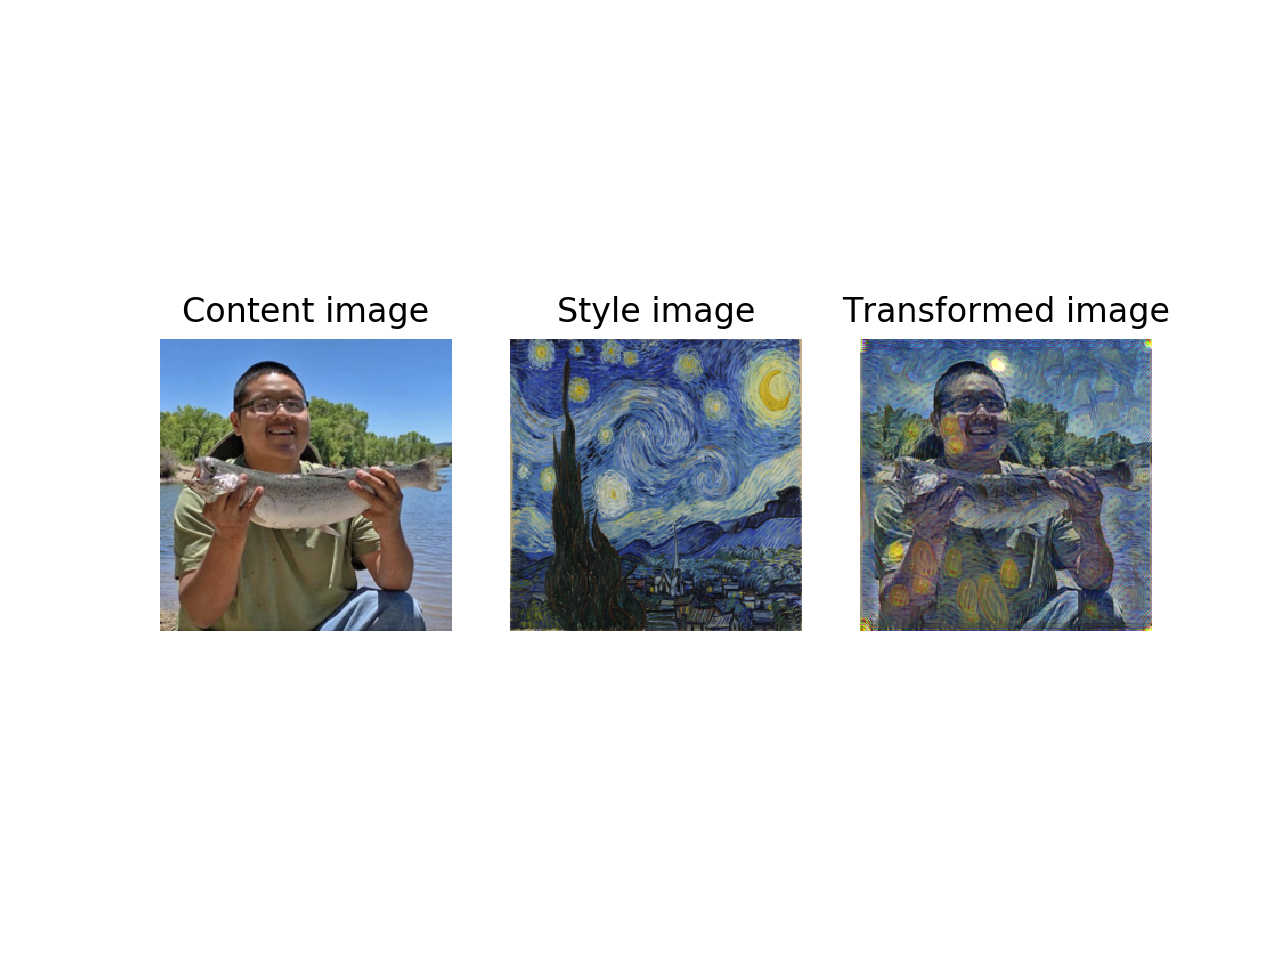

In [13]:
sample_x = image_loader(os.getcwd() + '/images/content_image/touchfish.jpg').to(device)
sample_x = sample_x.view([1, 3, 256, 256])
sample_y = transnet(sample_x.to(device))

plt.subplot(1, 3, 1)
plt.title('Content image')
imshow(np.squeeze(sample_x))
plt.subplot(1, 3, 2)
plt.title('Style image')
imshow(np.squeeze(style_img))
plt.subplot(1, 3, 3)
plt.title('Transformed image')
imshow(np.squeeze(sample_y.detach()))